In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

We are interested in the study of the bifurcations, we need to calculate the fixed points of the system.

The equations for the model are:

\begin{align}
\begin{split}
    \tau_E \frac{dE}{dt} &= -E + S(\omega_{EE} E - \omega_{EI} I + P_E) \\
    \tau_I \frac{dI}{dt} &= -I + S(\omega_{IE} E - \omega_{II} I + P_I) \\
\end{split}
\end{align}

- Quiescent: 

In [2]:
#Define function S
@njit
def S(x):
    return np.tanh(x)
# @njit
# def S(x):
#     """
#     S function
#     """
#     return np.tanh(x/2)/2

#Define S prime
@njit
def S_prime(x):
    return 1 - np.tanh(x)**2
# @njit
# def S_prime(x):
#     return 1/4*(1-np.tanh(x/2)**2)

#Define the System of equations
@njit
def wilson_covan (y, wEE, wEI, wIE, wII, P, t):
    E, I = y
    P_E, P_I = P
    tau_E, tau_I = t
    dEdt = (-E + S (wEE * E - wEI * I + P_E)) / tau_E
    dIdt = (-I + S (wIE * E - wII * I + P_I)) / tau_I
    return np.array([dEdt, dIdt])

#Define the Jacobian matrix 
@njit
def jacobian(y, wEE, wEI, wIE, wII, P, t):
    E, I = y
    P_E, P_I = P
    tau_E, tau_I = t

    dEdE = (-1 + wEE * S_prime(wEE * E - wEI * I + P_E))/tau_E
    dEdI = -wEI * S_prime(wEE * E - wEI * I +P_E) / tau_E
    dIdE = wIE * S_prime(wIE * E - wII * I + P_I) / tau_I
    dIdI = (-1 - wII*S_prime(wIE * E - wII * I + P_I))/ tau_I

    return np.array([dEdE, dEdI, dIdE, dIdI])


In [3]:
def fixed_points(wEE, wEI, wIE, wII, tol, initial_guess, P = ([0, 0]), t=[1, 1]):
    fixed_points = [[0, 0]]
    for guess in initial_guess:
        sol = optimize.root(wilson_covan, guess, args=(wEE, wEI, wIE, wII, P, t))
        if sol.success:
            if not any(np.allclose(sol.x, fp, atol=tol) for fp in fixed_points):
                fixed_points.append(sol.x)
    return np.array(fixed_points)

# Stability analysis (Jacobian method)
def stability_analysis(wEE, wIE, wEI, wII, fixed_points):
    stable = []
    for point in fixed_points:
        J = jacobian(point, wEE, wEI, wIE, wII, P=[0, 0], t=[1, 1])
        new_J = np.array([[J[0], J[1]], [J[2], J[3]]])
        eigenvalues = np.linalg.eigvals(new_J)
        if np.all(np.real(eigenvalues) < 0):
            stable.append("Stable")
        elif np.any(np.real(eigenvalues) > 0):
            stable.append("Unstable")
    return np.array(stable)

In [4]:
# Phase diagram
wEI, wII = 10, 1  # Fixed inhibitory parameters
wEE_values = np.linspace(0.1, 30, 250)
wIE_values = np.linspace(0.1, 20, 250)
stability_map = np.zeros((len(wEE_values), len(wIE_values)))

tol_EI = 1e-5 #The toletance in E and I, to consider if 2 close fixed points are the same.

N = 100
x = 2
initial_guesses = np.zeros((N, 2))

for i in range(N):
    initial_guesses[i] = np.array([np.random.uniform(-x, x), np.random.uniform(-x, x)])

for i, wEE in tqdm(enumerate(wEE_values)):
    for j, wIE in enumerate(wIE_values):
        fixed_point = fixed_points(wEE, wEI, wIE, wII, tol=tol_EI, initial_guess=initial_guesses)
        stabilities = stability_analysis(wEE, wEI, wIE, wII, fixed_point)
        if len(fixed_point) == 0 or (len(fixed_point) ==1 and np.count_nonzero(stabilities == "Unstable") == 1):
            stability_map[i, j] = 3  # Oscillatory
        elif len(fixed_point) == 1 and np.count_nonzero(stabilities == "Unstable") == 0:
            stability_map[i, j] = 1  # Quiescent
        else:
            stability_map[i, j] = 2  # Bistable

250it [23:10,  5.56s/it]


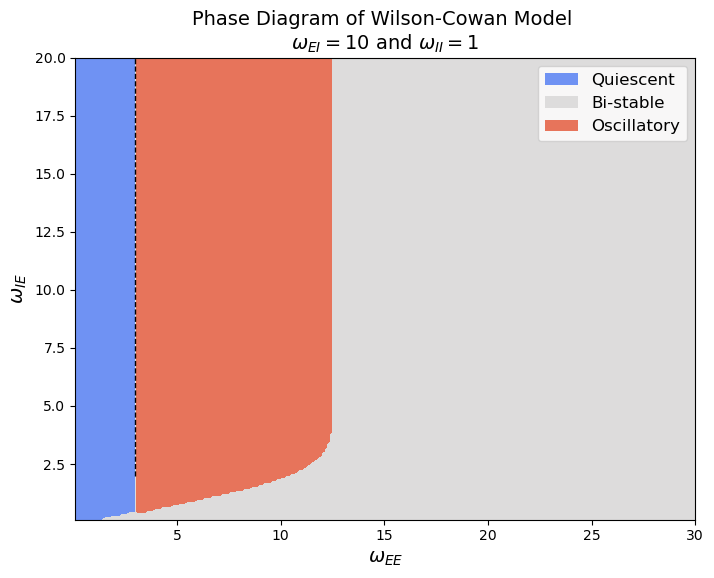

In [5]:
plt.figure(figsize=(8,6))
cs = plt.contourf(wEE_values, wIE_values, stability_map.T, levels=[0,1,2,3], cmap='coolwarm')
#plt.colorbar(label="1: Quiescent, 2: Bi-stable, 3: Oscillatory")
plt.xlabel(r"$\omega_{EE}$", fontsize = 14)
plt.ylabel(r"$\omega_{IE}$", fontsize = 14)
plt.vlines(3, 2, 20, colors='black', linestyles='dashed', lw=1)
plt.title("Phase Diagram of Wilson-Cowan Model \n"r"$\omega_{EI} = 10$ and $\omega_{II} = 1$", fontsize = 14)
h1,l1 = cs.legend_elements()
l1 = ['Quiescent', 'Bi-stable', 'Oscillatory']
plt.legend(h1, l1, fontsize = 12)
plt.show()